# So what?

In [72]:
import sympy as sp
import numpy as np
from sympy.interactive import printing
printing.init_printing(use_latex = True)

In [73]:
S_Pr_Tr = sp.Symbol("S(Pr, Tr)")
G_Pr_T  = sp.Symbol("G(Pr, T)")
G0,T,T_r = sp.symbols('G_0, T, T_r')
c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8 = sp.symbols('c_1, c_2, c_3, c_4, c_5, c_6, c_7, c_8')
b_1, b_5, b_6, b_7, b_8                = sp.symbols('b_1, b_5, b_6, b_7, b_8')

## Heat capacity at a given temperature and 1 bar

In Holland and Powell datasets, the heat capacity is expressed as the following polinomial with only $c_1$ to $c_5$ terms

$$ C_p = c_1 +c_2T +\frac{c_3}{T^2} + c_4T^2 + \frac{c_5}{\sqrt{T}} + \frac{c_6}{T} + \frac{c_7}{T^3} + c_8T^3 $$



Let's evaluate this for the case of forsterite in hp02ver.dat. It compares well (to the forth decima) with the value retrieved from frendly (175.0651)

In [74]:
def Cp(T):
    return c_1 +c_2*T +c_3/T**2 + c_4*T**2 + c_5/sp.sqrt(T) + c_6/T + c_7/T**3 + c_8*T**3
Cp(1000).subs({c_1:233.3, c_2:.1494E-2, c_3:-603800, c_4:0, c_5:-1869.7 , c_6:0, c_7:0, c_8:0}).evalf().round(4)

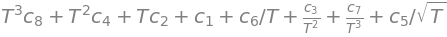

In [75]:
Cp(T)

## Entropy at a given temperature and 1 bar
We can now integrate the symbolic expression to compute the intregal $C_P/T$

In [76]:
CpoT_int = sp.integrate(Cp(T)/T,(T,T_r,T))

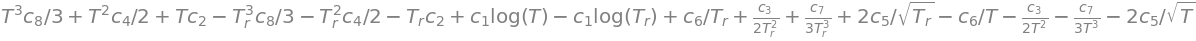

In [77]:
CpoT_int

In [78]:
fo = {'G0':-2053138, 'S0': 95.1, 'V0': 4.366}

We lambdify the expression to make it faster

In [79]:
int_CpoT = sp.lambdify(T, CpoT_int.subs({T_r:298.15, c_1:233.3, c_2:.1494E-2, c_3:-603800, 
                                       c_4:0, c_5:-1869.7 , c_6:0, c_7:0, c_8:0}), modules='sympy')
int_CpoT(1000).evalf()

and then finally we compute the entropy at 1 bar by adding the reference entropy. That compares with the frendly value (277.0713 J/mol/K)

In [80]:
fo_S = fo.get('S0') + int_CpoT(1000)
fo_S.evalf()

## Apparent gibbs enery at a given temperature and 1 bar

We can do similarly with enthalpy

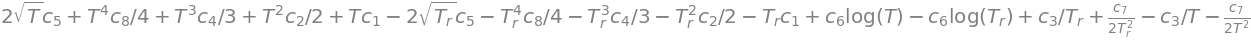

In [81]:
Cp_int   = sp.integrate(Cp(T),(T,T_r,T))
Cp_int

In [82]:
int_Cp   = sp.lambdify(T, Cp_int.subs({T_r:298.15, c_1:233.3, c_2:.1494E-2, c_3:-603800, 
                                       c_4:0, c_5:-1869.7 , c_6:0, c_7:0, c_8:0}))

In [83]:
def fo_G(T): 
    T_r = 298.15
    return(fo.get('G0') + fo.get('S0')*(T_r-T) - T*int_CpoT(T) + int_Cp(T))

that compares also very well with the value from frendly (-2192536 J/mol)

In [84]:
fo_G(1000).evalf()

## Apparent gibbs enery at a given temperature and pressure
### Volume at high pressure using the Murnaghan equation
It suffices to add to the above expression the volume integral
Holland and Powell expression
$$ \alpha_T = a^0 \left( 1 - \frac{10}{\sqrt(T)} \right) $$
$$ v(T,1) = v^0 [1 + a^0(T-T_r)-20a^0(\sqrt T-\sqrt T_r)] $$

in Perplex these are written as
$$ \alpha (T,P_r) = b_1 + b_5/\sqrt T $$

In [85]:
alpha, beta, kappa, kappa1, P, v, t, v_0 = sp.symbols("alpha, beta, \kappa, \kappa', P, v, t, v_0",
                                                     positive=True, real=True)

In [86]:
def alpha_T(T):
    return b_1 + b_5/sp.sqrt(T)

def alpha_T_int(t):
    return sp.integrate(alpha_T(t),(t,T_r,T))

def v_1(T): 
    return v_0.subs({v_0:4.366})*(1 + sp.integrate(alpha_T(t),(t,T_r,T)).subs({t:1000, b_1:.613E-4, b_5:-.613E-3})).evalf()

$$ V(T,P_r) = V_0·\left [1 + \int_{T_r}^{T}\alpha(T,P_r)dT \right] $$

In [87]:
T_r = 298.15
v_1(1000).round(6)

that compares with the frendly value 4.476770 J/mol/bar

In [88]:
def alpha_T(T):
    return b_1 + b_5/sp.sqrt(T)

def alpha_T_int(t):
    return sp.integrate(alpha_T(t),(t,T_r,T))

def v_1(T): 
    return v_0*(1 + sp.integrate(alpha_T(t),(t,T_r,T))).evalf()

v_1(T)

compresibility (1/bar) $\equiv v_0/\beta$
expansivity (1/K) $\equiv v_0*\alpha_T$

In [89]:
expansivity = 4.366*alpha_T(1000).subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()
expansivity

that compares with the frendly value (0.1829078E-03 1/K) at 1 bar 1000 K

$$K(T,P_r) = b_6 + b_7·(T-T_r) $$

Molar volume at T and P
$$ v(T,P) = v(T,1)\left [ 1-\frac{4P}{\kappa_T + 4P} \right]^{1/4} $$

In [90]:
def Kappa(T):
    return b_6 + b_7*(T-T_r)

In [91]:
def v(T,P):
    return v_1(T)*(1-4*P/(Kappa(T)+ 4*P))**(1/4)

In [92]:
v(298.15,1).subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()

In [93]:
v(1000,10000).subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()

that compares well with the value of frendly 4.437839 J/mol/bar at 1000 K and 10000 bar

### Contribution of the volume at P and T to the gibbs energy 

$$ \int_1^PV(T,P)dP= \frac{V(T,1)K_T}{3}\left [\left (1+\frac{4P}{K_T} \right)^{3/4}-1 \right]$$

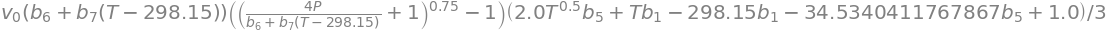

In [94]:
v_1(T)*Kappa(T)/3*((1+4*P/Kappa(T))**(3/4)-1)

In [95]:
def int_v(T,P):
    T_r = 298.15
    return v_1(T)*Kappa(T)/3*((1+4*P/Kappa(T))**(3/4)-1)

In [96]:
int_v(209.15,1).subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()

# symbolic volume integral

In [97]:
int_v(T,P).subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()

In [98]:
int_vdP = v_1(T)*Kappa(T)/3*((1+4*P/Kappa(T))**(3/4)-1)
int_vdP.subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()

## Another (my) way of getting the integralVdP

For some reason i am not getting the right answer using the hp expression 98, as i do to retrieve v0 for 1 bar. So i did myself the integral of the Murnaghan equation:

$$ P = \frac{\kappa}{\kappa'} \left[\left(\frac{V^0}{V}\right)^{\kappa'}-1\right]$$

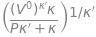

In [99]:
T, P, kappa, kappa1, V0, V, G_V = sp.symbols("T, P, \kappa, \kappa', V^0, V, G_V", 
                                        positive=True, real=True)

myequation = sp.Eq(P,kappa/kappa1*((V0/V)**kappa1-1))
display(myequation)
myequation_solved = sp.solve(myequation,V)
myequation_solved[0]

For $\kappa' =4 $

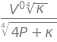

In [100]:
tointegrate = myequation_solved[0].subs({kappa1:4})
display(tointegrate)
myhp = sp.Integral(tointegrate,(P, 1, P))
myhp.doit().simplify()

In [101]:
print(myhp.doit().simplify())

V^0*\kappa**(1/4)*((4*P + \kappa)**(3/4) - (\kappa + 4)**(3/4))/3


In [102]:
int_vdP2 = v_1(T)*Kappa(T)**(1/4)*((4*P + Kappa(T))**(3/4) - (Kappa(T) + 4)**(3/4))/3
int_vdP2

In [103]:
print(int_vdP2)

v_0*(b_6 + b_7*(T - 298.15))**0.25*((4*P + b_6 + b_7*(T - 298.15))**0.75 - (b_6 + b_7*(T - 298.15) + 4)**0.75)*(2.0*T**0.5*b_5 + T*b_1 - 298.15*b_1 - 34.5340411767867*b_5 + 1.0)/3


# Symbolic G computation

In [104]:
def fo_G(T, P): 
    T_r = 298.15
    return fo.get('G0') + fo.get('S0')*(T_r-T) - T*int_CpoT(T) + int_Cp(T) + int_v(T,P)

In [105]:
fo_G(298.15,1).subs({T_r: 298.15,v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-109.5}).evalf()-4.366

that comapares quite well with the value from frendly -2147968 J at 10000 bar 1000 K

# All together now

Below a more condensed expression to compute the gibbs energy of an end-member, though not very elegant. 

In [106]:
import sympy as sp
import numpy as np
from sympy.interactive import printing
printing.init_printing(use_latex = True)

S_Pr_Tr = sp.Symbol("S(Pr, Tr)")
G0,S0, T, P, T_r = sp.symbols('G_0, S0, T, P, T_r')

c_1, c_2, c_3, c_5 = sp.symbols('c_1, c_2, c_3, c_5')
b_1, b_5, b_6, b_7 = sp.symbols('b_1, b_5, b_6, b_7')
alpha, beta, kappa, P, v_0  = sp.symbols("alpha, beta, \kappa, P, v_0")

def Cp(T):
    return c_1 +c_2*T +c_3/T**2 + c_5/sp.sqrt(T)

CpoT_int = sp.integrate(Cp(T)/T,(T,T_r,T))
Cp_int   = sp.integrate(Cp(T),(T,T_r,T))

def alpha_T(T):
    return b_1 + b_5/sp.sqrt(T)

def alpha_T_int(t):
    return sp.integrate(alpha_T(t),(t,T_r,T))

def v_1(T): 
    return v_0*(1 + sp.integrate(alpha_T(t),(t,T_r,T))).evalf()

def Kappa(T):
    return b_6 + b_7*(T-T_r)

int_vdP = v_1(T)*Kappa(T)/3*((1+4*P/Kappa(T))**(3/4)-1)


In [107]:
v_1(T).subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()

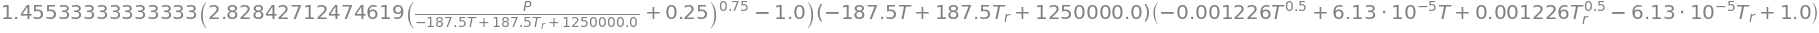

In [108]:
int_vdP.subs({v_0:4.366, b_1:.613E-4, b_5:-.613E-3, b_6:1250000, b_7:-187.5}).evalf()

In [111]:
def G(t,p,phase):
    T_r = 298.15
    CpoT_int = sp.integrate(Cp(T)/T,(T,T_r,T)).subs({c_1:phase.get('c_1'), 
                                                 c_2:phase.get('c_2'), 
                                                 c_3:phase.get('c_3'), 
                                                 c_5:phase.get('c_5')})

    Cp_int   = sp.integrate(Cp(T),(T,T_r,T)).subs({c_1:phase.get('c_1'), 
                                               c_2:phase.get('c_2'), 
                                               c_3:phase.get('c_3'), 
                                               c_5:phase.get('c_5')})


    alpha_T_int = (sp.integrate(phase.get('b_1') 
                                + phase.get('b_5')/sp.sqrt(T),(T,T_r,T)))
    
    v_1         = phase.get('V0')*(1 + alpha_T_int)
    kappa       = phase.get('b_6') + phase.get('b_7')*(T-T_r)

    int_v       = v_1*kappa/3*((1+4*P/kappa)**(3/4)-1)
    return (phase.get('G0') + phase.get('S0')*(T_r-t) - t*CpoT_int.subs({T:t}) + Cp_int.subs({T:t}) 
            + int_v.subs({T:t,P:p}))

In [122]:
G(298.15, 1, fo).evalf()

## Symbolic expression for G

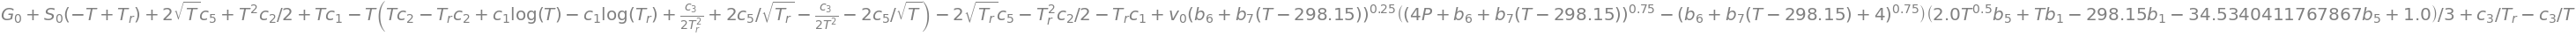

In [113]:
Gs = G0 + S0*(T_r-T) - T*CpoT_int + Cp_int + int_vdP2
Gs

In [114]:
Gs.subs({'S0': 95.1,'G_0':-2053138,T:1000,T_r:298.15, c_1:233.3, c_2:.1494E-2, c_3:-603800, 
                                       c_4:0, c_5:-1869.7 , c_6:0, c_7:0, c_8:0}).evalf()

In [115]:
print(Gs)

G_0 + S0*(-T + T_r) + 2*sqrt(T)*c_5 + T**2*c_2/2 + T*c_1 - T*(T*c_2 - T_r*c_2 + c_1*log(T) - c_1*log(T_r) + c_3/(2*T_r**2) + 2*c_5/sqrt(T_r) - c_3/(2*T**2) - 2*c_5/sqrt(T)) - 2*sqrt(T_r)*c_5 - T_r**2*c_2/2 - T_r*c_1 + v_0*(b_6 + b_7*(T - 298.15))**0.25*((4*P + b_6 + b_7*(T - 298.15))**0.75 - (b_6 + b_7*(T - 298.15) + 4)**0.75)*(2.0*T**0.5*b_5 + T*b_1 - 298.15*b_1 - 34.5340411767867*b_5 + 1.0)/3 + c_3/T_r - c_3/T


## With all parameters

In [116]:
fo = {'G0' :-2053138, 
      'S0' : 95.1, 
      'V0' : 4.366, 
      'c_1': 233.3, 'c_2':.1494E-2, 'c_3':-603800, 'c_5':-1869.7, 
      'b_1':.613E-4,'b_5':-.613E-3, 'b_6':1250000, 'b_7':-109.5,
      'c_4': 0     ,'c_6':  0     , 'c_7':0      , 'c_8':0     ,
      'b_8': 0
     }

In [117]:
def g(T,P,phase):
    T_r = 298.15
    return (
    phase.get('G0')                    + 
    phase.get('S0')*(T_r - T)          +

    2*np.sqrt(T)*phase.get('c_5')      - 2*np.sqrt(T_r)*phase.get('c_5') +
    T**2*phase.get('c_2')/2            - T_r**2*phase.get('c_2')/2       +
    T*phase.get('c_1')                 - T_r*phase.get('c_1')            +
    phase.get('c_3')/T_r               - phase.get('c_3')/T              - 
    
    T*(T*phase.get('c_2')              - T_r*phase.get('c_2')            + 
       phase.get('c_1')*np.log(T)      - phase.get('c_1')*np.log(T_r)    + 
       phase.get('c_3')/(2*T_r**2)     - phase.get('c_3')/(2*T**2)       + 
       2*phase.get('c_5')/np.sqrt(T_r) - 2*phase.get('c_5')/np.sqrt(T))  +
    
    phase.get('V0')                                                 *
    (phase.get('b_6') + phase.get('b_7')*(T - T_r))**0.25           *
    ((4*P + phase.get('b_6') + phase.get('b_7')*(T - T_r))**0.75 - 
     (4   + phase.get('b_6') + phase.get('b_7')*(T - T_r))**0.75)   *
    (2.0*T**0.5*phase.get('b_5') - 2.0*T_r**0.5*phase.get('b_5')    + 
     T*phase.get('b_1')          - T_r*phase.get('b_1') + 1.0)/3
    )


In [118]:
g(298.15, 1, fo)

In [119]:
g(2500, 1, fo)

In [120]:
g(2500, 10000, fo)

In [121]:
g(1000, 10000, fo)